In [10]:

from models.Linear import Model
import sys

import argparse
parser = argparse.ArgumentParser(description='Autoformer & Transformer family for Time Series Forecasting')
parser.add_argument('--random_seed', type=int, default=2021, help='random seed')

# basic config
parser.add_argument('--is_training', type=int,  default=1, help='status')
parser.add_argument('--model_id', type=str,  default='test', help='model id')
parser.add_argument('--model', type=str,  default='Linear',
                    help='model name, options: [Autoformer, Informer, Transformer]')

# data loader
parser.add_argument('--data', type=str,  default='custom', help='dataset type')
parser.add_argument('--root_path', type=str, default='/ssddata/data/jiahuili/PatchTST/all_six_datasets/weather/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='weather.csv', help='data file')
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

# forecasting task
parser.add_argument('--seq_len', type=int, default=336, help='input sequence length')
parser.add_argument('--label_len', type=int, default=0, help='start token length')
parser.add_argument('--pred_len', type=int, default=720, help='prediction sequence length')


# DLinear
#parser.add_argument('--individual', action='store_true', default=False, help='DLinear: a linear layer for each variate(channel) individually')

# PatchTST
parser.add_argument('--fc_dropout', type=float, default=0.05, help='fully connected dropout')
parser.add_argument('--head_dropout', type=float, default=0.0, help='head dropout')
parser.add_argument('--patch_len', type=int, default=16, help='patch length')
parser.add_argument('--stride', type=int, default=8, help='stride')
parser.add_argument('--padding_patch', default='end', help='None: None; end: padding on the end')
parser.add_argument('--revin', type=int, default=1, help='RevIN; True 1 False 0')
parser.add_argument('--affine', type=int, default=0, help='RevIN-affine; True 1 False 0')
parser.add_argument('--subtract_last', type=int, default=0, help='0: subtract mean; 1: subtract last')
parser.add_argument('--decomposition', type=int, default=0, help='decomposition; True 1 False 0')
parser.add_argument('--kernel_size', type=int, default=25, help='decomposition-kernel')
parser.add_argument('--individual', type=int, default=0, help='individual head; True 1 False 0')

# Formers 
parser.add_argument('--embed_type', type=int, default=0, help='0: default 1: value embedding + temporal embedding + positional embedding 2: value embedding + temporal embedding 3: value embedding + positional embedding 4: value embedding')
parser.add_argument('--enc_in', type=int, default=21, help='encoder input size') # DLinear with --individual, use this hyperparameter as the number of channels
parser.add_argument('--dec_in', type=int, default=21, help='decoder input size')
parser.add_argument('--c_out', type=int, default=21, help='output size')
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')
parser.add_argument('--itr', type=int, default=1, help='experiments times')
parser.add_argument('--train_epochs', type=int, default=100, help='train epochs')
parser.add_argument('--batch_size', type=int, default=128, help='batch size of train input data')
parser.add_argument('--patience', type=int, default=10, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='test', help='exp description')
parser.add_argument('--loss', type=str, default='mse', help='loss function')
parser.add_argument('--lradj', type=str, default='type3', help='adjust learning rate')
parser.add_argument('--pct_start', type=float, default=0.3, help='pct_start')
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')
parser.add_argument('--test_flop', action='store_true', default=False, help='See utils/tools for usage')
args,unkown = parser.parse_known_args()
model=Model(args)

In [13]:
import torch
model = model.to('cuda:0')
model.load_state_dict(torch.load('/ssddata/data/jiahuili/checkpoints/test_Linear_custom2_ftM_sl336_ll0_pl720_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_test_0/checkpoint.pth'))
model.eval()
from data_provider.data_factory import data_provider
import matplotlib.pyplot as plt
test_data, test_loader = data_provider(args,flag='test')

test 9820


0.35872668
0.3804184
0.47528875
0.59067667
0.6286754
0.6435304
0.6532856
0.61342406
0.5250601
0.48173502
0.4534164
0.50396866
0.53932035
0.67820156
0.8315728
0.989577
0.9712005
0.9251463
0.77004635
0.70755655
0.66519856
0.66217893
0.66600025
0.57533395
0.48063996
0.4644688
0.474629
0.4957114
0.587937
0.6524297
0.7716164
0.82613295
0.84922326
0.90808225
0.93476355
0.8568082
0.7567046
0.78087324
0.82654625
0.82456815
0.8129368
0.8306972
0.81940025
0.84533525
0.849278
0.878369
0.9044627
0.88281107
0.8619141
0.81552714
0.7156153
0.7322843
0.75951385
0.78375286
0.8093742
0.82809126
0.8030017
0.7883506
0.7302338
0.6711089
0.688859
0.73160475
0.75309277
0.7864214
0.8686941
0.8725153
0.7714547
0.71160024
0.663667
0.68352133
0.796764
0.9270648
1.0998703
1.1829019
1.1053504
1.0019447


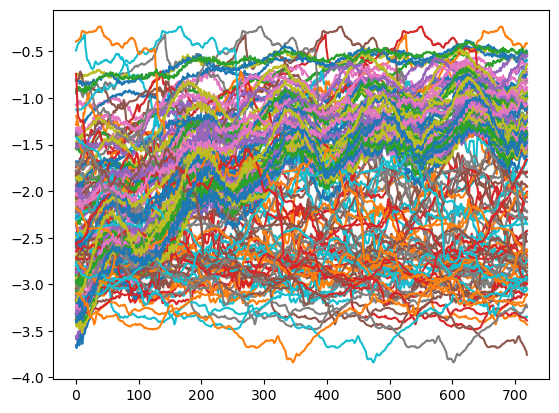

In [18]:



import numpy as np

with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
                # (batch_x, batch_y, batch_x_mark, batch_y_mark) =next(iter(test_loader))
                
                
                
                batch_x=batch_x.float().to('cuda:0')
                batch_y=batch_y.float().to('cuda:0')
                outputs = model(batch_x)
                
                

                
                

                pred = outputs.detach().cpu().numpy()  # outputs.detach().cpu().numpy()  # .squeeze()
                true = batch_y.detach().cpu().numpy()  # batch_y.detach().cpu().numpy()  # .squeeze()
                plt.plot(pred[0,:,6])
                plt.plot(true[0,:,6])

                mean_value=abs(pred-true).mean()    
                print(mean_value)   
# mean_value=abs(pred-true).mean()    
# mean_value   
                